In [5]:
from gammapy.irf import EffectiveAreaTable2D,EnergyDispersion2D
from regions import CircleSkyRegion
from gammapy.makers import SafeMaskMaker,PhaseBackgroundMaker,SpectrumDatasetMaker
from gammapy.maps import Map, WcsGeom, MapAxis, RegionGeom
from gammapy.data import DataStore, EventList, Observation, Observations
from gammapy.datasets import Datasets, SpectrumDataset, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
from gammapy.data import GTI

In [6]:
import astropy.units as u
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from astropy.coordinates import SkyCoord,Angle
from astropy.table import unique
from lstchain.io import get_srcdep_params
from lstchain.io.io import dl2_params_lstcam_key
from matplotlib.gridspec import GridSpec

## Useful functions

In [7]:
#Function to find all the files that are in a directory and contain a string condition in the name
def find_files_in_dir(directory,condition):
    filelist=[]
    for x in os.listdir(directory):
            p_dir = os.path.relpath(directory)
            p_file = os.path.join(directory, x)
            if condition in p_file:
                filelist.append(p_file)
    return(filelist)

In [8]:
#Function to shift all the negative phases in a list (PINT gives phases from [-0.5,0.5] but we need them in [0,1])
def shift_negative_phases(phases):
    for i in range(0,len(phases)):
        if phases[i]<0:
            phases[i]=phases[i]+1
    return(phases)

# 1. Define the arguments to be used

In [9]:
off_phase_range = (0.52,0.87)
on_phase_range_P2 = (0.377,0.422)
on_phase_range_P1_1 = (0,0.026)
on_phase_range_P1_2 = (0.983,1)
bridge_phase=(0.026,0.377)

In [10]:
DL3_direc='/fefs/aswg/workspace/alvaro.mas/data/real/Crab/src_dependent/v0.9_crab/DL3_pulsar/'
DL2_direc='/fefs/aswg/workspace/alvaro.mas/data/real/Crab/src_dependent/v0.9_crab/DL2_pulsar/'

In [11]:
target_position = SkyCoord(ra=83.633*u.deg, dec= 22.01*u.deg, frame="icrs")
on_region_radius = Angle("0.2deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [12]:
e_true = MapAxis.from_energy_bounds(0.003, 50, 60, unit="TeV", name="energy_true")
e_reco = MapAxis.from_energy_bounds(0.03, 10, 40, unit="TeV", name="energy")
max_zen = 35 

# 2. Create Observations objects with the infor from DL3 and the phases from DL2

In [14]:
total_datastore = DataStore.from_dir(DL3_direc)
obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]

In [16]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations = total_datastore.get_observations(total_obs_list, required_irf=None)

No HDU found matching: OBS_ID = 2913, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2913, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2913, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2914, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2914, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2914, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2929, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2929, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2929, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2930, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2930, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2930, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2931, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2931, HDU_TYPE = bkg, HDU_CLA

No HDU found matching: OBS_ID = 3243, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3243, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3243, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3270, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3270, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3270, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3271, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3271, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3271, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3272, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3272, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3272, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3273, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3273, HDU_TYPE = bkg, HDU_CLA

No HDU found matching: OBS_ID = 3673, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3673, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3673, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3674, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3674, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3674, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3675, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3675, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3675, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3676, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3676, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3676, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3677, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3677, HDU_TYPE = bkg, HDU_CLA

In [17]:
d_zen = [total_datastore.obs_table["ZEN_PNT"]<max_zen]

obs_table = total_datastore.obs_table[d_zen[0]]
obs_list = total_datastore.obs_table[d_zen[0]]["OBS_ID"]

In [18]:
print('Wobble observation runs selected are:', obs_list)
print('Name of the source:'+str(obj_name))
print(f'Total livetime of all observations: {total_datastore.obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')
print(f'Total livetime of all selected wobble observations {obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')

Wobble observation runs selected are: OBS_ID
------
  2913
  2914
  2929
  2930
  2931
  2932
  2933
   ...
  6895
  7086
  7097
  7098
  7099
  7133
  7136
Length = 112 rows
Name of the source:Crab
Total livetime of all observations: 33.949 hrs
Total livetime of all selected wobble observations 33.949 hrs


In [91]:
#New observation list 
observation_list=[]

for j in range(0,30): #Loop over the observations
    print('Reading observation: '+str(obs_list[j]))
    
    #Read the DL2 files that will be used (since we are now working with subruns, there are multiple DL2 files for 1 run )
    DL2_filelist=find_files_in_dir(DL2_direc,str(obs_list[j]))
    
    #Read the DL3-table and extract the times
    table=unique(observations[j].events.select_region(on_region).table,'TIME') # We only need the ON region
    times=table['TIME']

    #Read the Dl2 events 
    df_list=[]
    for file in DL2_filelist:
        df_i=pd.read_hdf(file,key=dl2_params_lstcam_key)
        df_i=df_i[['trigger_time','pulsar_phase']]
        df_i['pulsar_phase']=shift_negative_phases(df_i.pulsar_phase.to_list()) #PINT gives phases from [-0.5,0.5] but we need them in [0,1])
        df_list.append(df_i)
    df = pd.concat(df_list)
    
    #Filter using the times to keep only events that survived in the DL3 file
    df=df[df['trigger_time'].isin(times)]
    df=df.sort_values('trigger_time')
    
    #Create the new table with the phases
    table['PHASE']=df.pulsar_phase
    Events=EventList(table=table)
    
    #Create an observation for object with this new table and set the same IRFs and append to the list
    obs=Observation(obs_id=observations[j].obs_id,obs_info=observations[j].obs_info,events=Events,
                    gti=observations[j].gti,aeff=observations[j].aeff,edisp= observations[j].edisp)
    observation_list.append(obs)

print('Finished reading and adding phases')

Reading observation: 2913
Reading observation: 2914
Reading observation: 2929
Reading observation: 2930
Reading observation: 2931
Reading observation: 2932
Reading observation: 2933
Reading observation: 2934
Reading observation: 2949
Reading observation: 2950
Reading observation: 2955
Reading observation: 2967
Reading observation: 2968
Reading observation: 2969
Reading observation: 2970
Reading observation: 2971
Reading observation: 2972
Reading observation: 2973
Reading observation: 2974
Reading observation: 2975
Reading observation: 2976
Reading observation: 2977
Reading observation: 2988
Reading observation: 2989
Reading observation: 2990
Reading observation: 2991
Reading observation: 2992
Reading observation: 3004
Reading observation: 3005
Reading observation: 3006
Finished reading and adding phases


In [92]:
observation_list[0].events.table

EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,MULTIP,GLON,GLAT,ALT,AZ,PHASE
,s,deg,deg,TeV,,,deg,deg,deg,deg,
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float128
600,1605669688.4044366,83.63308333002661,22.014499999992164,0.03369900371567072,0.7061666666666666,1,184.55745787701582,-5.784356705760376,81.26665239039687,220.94787795499155,0.61882333957423973914
663,1605669688.4159842,83.63308333002662,22.01449999999217,0.03802535364574506,0.6504166666666665,1,184.55745787701582,-5.784356705760365,81.26662467171515,220.94810912221547,0.9606582128386005337
691,1605669688.4202096,83.63308333002662,22.014499999992182,0.040890626189391766,0.5368333333333333,1,184.55745787701582,-5.784356705760357,81.26661452884547,220.94819371072234,0.08575468388703733069
722,1605669688.426301,83.63308333002662,22.014499999992164,0.07861603964677227,0.7915833333333333,1,184.55745787701582,-5.784356705760366,81.26659990712558,220.94831565092048,0.2660588258386749061
726,1605669688.426826,83.63308333002664,22.014499999992186,0.021598789553003855,0.8254999999999998,1,184.55745787701582,-5.7843567057603344,81.26659864691773,220.94832616059568,0.2815967791630580308
934,1605669688.4642048,83.63308333002662,22.01449999999218,0.08769436410190176,0.5971428571428571,1,184.55745787701582,-5.784356705760358,81.26650892190311,220.94907442143705,0.38812891220964296224
...,...,...,...,...,...,...,...,...,...,...,...
5782725,1605670866.8124604,83.63308333003476,22.01449999999465,0.07016645133184272,0.7981666666666666,1,184.55745787701775,-5.784356705752659,77.94231051994853,238.5678216952819,0.86289891784058703195


# 3. Define makers

In [93]:
# Create Makers
geom = RegionGeom.create(region=on_region, axes=[e_reco])
dataset_empty = SpectrumDataset.create(geom=geom,energy_axis_true=e_true)

In [94]:
dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"],
                                     use_region_center=True)

In [95]:
# Define background maker with the phase regions
bkg_maker_P1 = PhaseBackgroundMaker(on_phase=[on_phase_range_P1_1,on_phase_range_P1_2], off_phase=off_phase_range)
bkg_maker_P2 = PhaseBackgroundMaker(on_phase=on_phase_range_P2, off_phase=off_phase_range)

In [96]:
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

# 4. Run makers on the observations to get the Datasets

### For P2 as an example

In [129]:
# The final object will be stored as a Datasets object
datasets_P2 = Datasets()

for obs_id, observation in zip(total_obs_list, observation_list):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    
    dataset_on_off = bkg_maker_P2.run(dataset=dataset, observation=observation)
    #dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    
    # Add the name of the observed source
    dataset_on_off.meta_table["SOURCE"]='Crab'
    
    datasets_P2.append(dataset_on_off)  

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used wi

In [130]:
dataset_stacked_P2 = Datasets(datasets_P2).stack_reduce()

In [131]:
dataset_stacked_P2.info_dict()

{'name': '4eMpBKVW',
 'counts': 52736,
 'background': 51376.3828125,
 'excess': 1359.6172,
 'sqrt_ts': 5.618940746457077,
 'npred': 51531.27304408599,
 'npred_background': 51531.27304408599,
 'npred_signal': nan,
 'exposure_min': <Quantity 45987020. m2 s>,
 'exposure_max': <Quantity 1.44132854e+10 m2 s>,
 'livetime': <Quantity 33595.71661785 s>,
 'ontime': <Quantity 35372.08850241 s>,
 'counts_rate': <Quantity 1.56972392 1 / s>,
 'background_rate': <Quantity 1.52925396 1 / s>,
 'excess_rate': <Quantity 0.04046996 1 / s>,
 'n_bins': 40,
 'n_fit_bins': 40,
 'stat_type': 'wstat',
 'stat_sum': 62.449510784940045,
 'counts_off': 399594,
 'acceptance': 40.0,
 'acceptance_off': 311.1110421754159,
 'alpha': 0.12857145071029663}

# 5. Do the Fitting

In [137]:
emin_fit, emax_fit = (0.025 * u.TeV,  100 * u.TeV)
spectral_model = PowerLawSpectralModel(index=2.9, 
                                        amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), 
                                        reference=0.15 * u.TeV)
model_P2 = SkyModel(spectral_model=spectral_model, name="crab P2")

In [138]:
dataset_stacked_P2.models = model_P2
dataset_stacked_P2.mask_fit = dataset_stacked_P2.counts.geom.energy_mask(emin_fit, emax_fit)

stacked_fit = Fit()
result_stacked_P2 = stacked_fit.run([dataset_stacked_P2])

# make a copy to compare later
model_best_stacked_P2 = model_P2.copy()

In [139]:
model_best_stacked_P2.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,index,3.1023e+00,,2.135e-01,nan,nan,False,
spectral,amplitude,2.9484e-11,cm-2 s-1 TeV-1,8.733e-12,nan,nan,False,
spectral,reference,1.5000e-01,TeV,0.000e+00,nan,nan,True,


# 6. Obtain spectral points

In [140]:
min_ts=1.5 #Limit for the UL
e_min, e_max = 0.025, 1
energy_edges = np.geomspace(e_min, e_max, 7) * u.TeV

In [141]:
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab P2", selection_optional="all")
flux_points_P2 = fpe.run(datasets=dataset_stacked_P2)

In [142]:
flux_points_P2.is_ul = flux_points_P2.sqrt_ts < min_ts

In [143]:
flux_points_P2.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.037,0.030,0.046,2.196e-09,6.420e-10,6.433e-10,6.408e-10,3.485e-09,11.861,3.444,18864.823455127713,497.4702,0.409,False,18867.0,True,0.200 .. 5.000,7.954 .. 180.645
0.062,0.046,0.083,3.982e-10,1.488e-10,1.491e-10,1.485e-10,6.972e-10,7.251,2.693,17333.455791025488,373.39648,9.345,False,17347.0,True,0.200 .. 5.000,13.641 .. 161.797
0.111,0.083,0.148,1.032e-10,3.383e-11,3.393e-11,3.374e-11,1.715e-10,9.508,3.083,9861.458617341961,320.74698,0.483,False,9862.0,True,0.200 .. 5.000,7.405 .. 62.898
0.213,0.148,0.306,1.172e-11,5.531e-12,5.554e-12,5.508e-12,2.288e-11,4.578,2.140,4455.071687312466,149.9951,1.440,False,4455.0,True,0.200 .. 5.000,4.591 .. 45.804
0.410,0.306,0.548,2.765e-13,1.392e-12,1.403e-12,nan,3.103e-12,0.039,0.199,1311.3098951033076,7.6352086,0.642,True,1312.0,True,0.200 .. 5.000,0.642 .. 19.541
0.732,0.548,0.979,2.360e-14,4.246e-13,4.297e-13,nan,8.959e-13,0.004,0.062,563.1126277911592,1.3985227,2.112,True,562.0,True,0.200 .. 5.000,2.114 .. 7.900


# 7. Plot the spectrum

In [153]:
ref_label="P1P2 MAGIC"

e_plot_min = 0.025 * u.TeV
e_plot_max = 1 * u.TeV


ds_kwargs = {
    "sed_type": "dnde",
    "energy_bounds": [e_plot_min, e_plot_max],
    "yunits": u.Unit("erg-1 cm-2 s-1"),
}

sed_kwargs_P2 = {
    "sed_type": "e2dnde",
    "energy_bounds": [e_plot_min, e_plot_max],
    "yunits": u.Unit("erg cm-2 s-1"),
    "color":'red'
}

sed_plot_kwargs_P2 = {
    "label": "P1 LST-1 data",
    "color":'red'
}
plot_ts_kwargs = {
    "color": "darkorange",
}

Text(0.5, 1.0, 'TS Profiles')

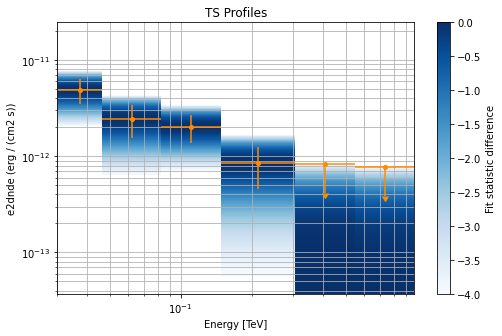

In [145]:
plt.figure(figsize=(8,5))
ax = flux_points_P2.plot(sed_type="e2dnde", **plot_ts_kwargs)

flux_points_P2.plot_ts_profiles(ax=ax, sed_type="e2dnde")

plt.grid(which='both')
plt.title('TS Profiles')

<AxesSubplot:>

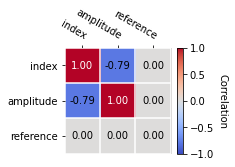

In [146]:
# Fit model covariance matrix plot
model_best_stacked_P2.covariance.plot_correlation()

(0.025, 1.0)

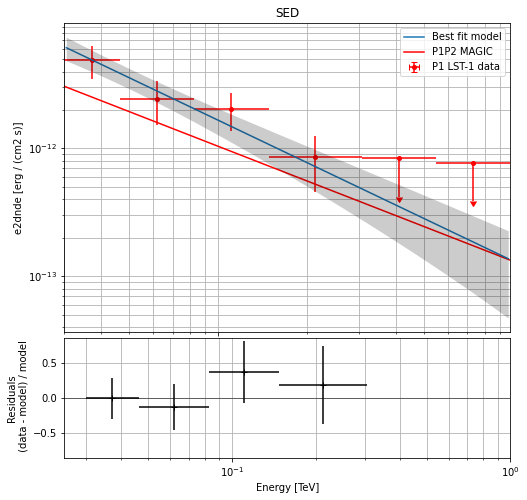

In [154]:
fig_sed = plt.figure(figsize=(8,8))
gs2 = GridSpec(7, 1)
gs2.update(hspace=0.1)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_sed.add_subplot(*args1)
fig_gs2 = fig_sed.add_subplot(*args2)

f=FluxPointsDataset(data=flux_points_P2, models=model_best_stacked_P2)
f.plot_spectrum(ax=fig_gs1, kwargs_fp=sed_plot_kwargs_P2)
f.plot_residuals(ax=fig_gs2, method='diff/model')

ref_model = spectral_model = PowerLawSpectralModel(index=2.9, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), 
                                                    reference=0.15 * u.TeV)
ref_model.plot(ax=fig_gs1, **sed_kwargs_P2, label=ref_label)

fig_gs1.legend()
fig_gs1.grid(which='both')
fig_gs1.set_title('SED')

fig_gs2.grid(which='both')
fig_gs2.set_xlim(e_plot_min.value, e_plot_max.value)